In [25]:
import pandas as pd
from pandas import DataFrame
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv('data/DailyDelhiClimateTrain.csv', low_memory=False)
print(df.head())
df.describe()


         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


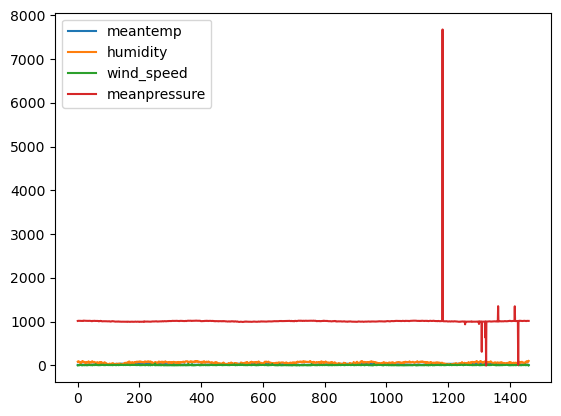

In [26]:
df.plot()
pyplot.show()

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1462
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2770.149
Date:                Tue, 14 May 2024   AIC                           5552.297
Time:                        18:26:03   BIC                           5584.019
Sample:                    01-01-2013   HQIC                          5564.130
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2122      0.021     -9.896      0.000      -0.254      -0.170
ar.L2         -0.1524      0.024     -6.317      0.000      -0.200      -0.105
ar.L3         -0.1827      0.025     -7.229      0.0

/Users/maksymmalicki/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maksymmalicki/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/maksymmalicki/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


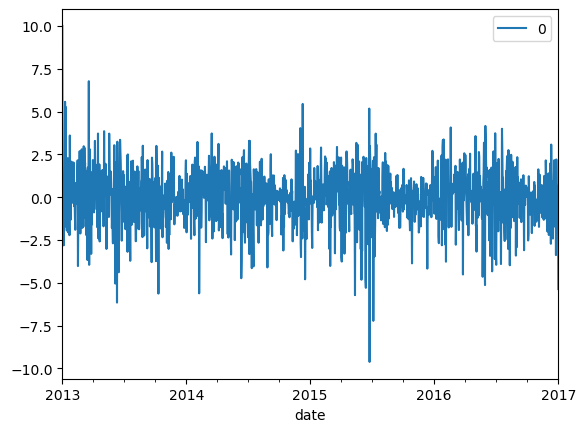

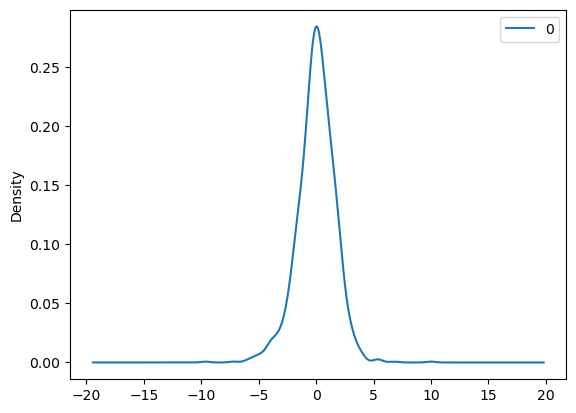

                 0
count  1462.000000
mean      0.009675
std       1.632545
min      -9.625116
25%      -0.871302
50%       0.074147
75%       1.022625
max      10.000000


In [27]:
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
model = ARIMA(df['meantemp'], order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()
# summary stats of residuals
print(residuals.describe())